# Predict Wild Blueberry Yield | Kaggle Playground Series S3
#### By *Saurabh Kudesia* | June 2025 
[![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/saurabh-kudesia) [![Kaggle](https://img.shields.io/badge/Kaggle-20BEFF?style=flat&logo=kaggle&logoColor=white)](https://www.kaggle.com/saurabhkudesia) [![LinkedIn](https://img.shields.io/badge/LinkedIn-0A66C2?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/saurabhkudesia/)


---
© 2025 Saurabh Kudesia

*This project is licensed under the [MIT License](https://opensource.org/licenses/MIT). You are free to use, modify, and distribute this code, provided you include proper attribution and retain the license notice.* 

[![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT) 

<img src="https://images.unsplash.com/photo-1597474561103-0773c378a1fb?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Blueberry" width="100%" style="margin-bottom: 10px;">

*Image Courtsey: [Unsplash.com](https://unsplash.com)*

# Introduction
-------

## Context
Blueberries are nutrient-rich, perennial shrubs known for their vibrant blue or purple berries. Native to North America, they come in two main types: lowbush (wild) and highbush (cultivated). Lowbush blueberries grow closer to the ground and produce smaller, intensely flavored berries, while highbush varieties are taller and yield larger fruit. Canada dominates lowbush blueberry production, while the U.S. leads in highbush cultivation.

## Goal
Build a regression model to predict the yield of wild blueberries based on various agronomic and environmental factors.

## Data Dictionary
The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Wild blueberry Yield Prediction](https://www.kaggle.com/datasets/shashwatwork/wild-blueberry-yield-prediction-dataset) Dataset. Feature distributions are close to, but not exactly the same, as the original. 

- id: Unique identifier for each entry
- Clonesize: The average blueberry clone size in the field
- Honeybee: Honeybee density in the field
- Bumbles: Bumblebee density in the field
- Andrena: Andrena bee density in the field
- Osmia: Osmia bee density in the field
- MaxOfUpperTRange: The highest record of the upper band daily air temperature (in ℃)during the bloom season
- MinOfUpperTRange: The lowest record of the upper band daily air temperature (in ℃)
- AverageOfUpperTRange:The average of the upper band daily air temperature (in ℃)
- MaxOfLowerTRange: The highest record of the lower band daily air temperature (in ℃)
- MinOfLowerTRange: The lowest record of the lower band daily air temperature (in ℃)
- AverageOfLowerTRange: The average of the lower band daily air temperature (in ℃)
- RainingDays: The total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays:The average of raining days of the entire bloom season
- fruitset: The percentage of flowers that successfully developed into fruit. Indicates reproductive success.
- fruitmass: The average mass (typically in grams) of individual blueberries. Reflects fruit quality and size.
- seeds: The average number of seeds per berry. Can be related to pollination effectiveness and fruit development.
- yield: The total blueberry production, usually measured in mass (e.g., kg or g) per area or per plant.


## Files
- `train.csv`: the training dataset; yield is the target
- `test.csv`: the test dataset; your objective is to predict the yield given the other features
- `sample_submission.csv` a sample submission file in the correct format 

# Import Libraries, Modules and Data
-----------

## Import Libraries

In [17]:
#general
import io

# data
import numpy as np
import pandas as pd

# machine learning
from tensorflow import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 3 = errors only
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

print (" ✅ All required modules successfully loaded.")

 ✅ All required modules successfully loaded.


## Load the dataset

In [18]:
df_train = pd.read_csv("/kaggle/input/pascmlsig/train.csv")
df_test = pd.read_csv("/kaggle/input/pascmlsig/test.csv")

print (" ✅ Dataset successfully loaded.")

 ✅ Dataset successfully loaded.


## Define Helper Functions

In [19]:
# Build and compile a linear regression model
def build_model(my_learning_rate, num_features):
  
  # Define model architecture: a single dense layer with 1 output
  inputs = keras.Input(shape=(num_features,))
  outputs = keras.layers.Dense(units=1)(inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model with RMSprop optimizer and MAE loss
  model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
    loss="mean_absolute_error",
    metrics=[keras.metrics.MeanAbsoluteError()]
  )

  return model


# Train the linear regression model
def train_model(model, features, label, epochs, batch_size):
  

  # Train the model for the specified number of epochs
  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Extract trained weights and bias
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # Extract training history
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mae = hist["mean_absolute_error"]  # Track MAE across epochs

  return trained_weight, trained_bias, epochs, mae


# Complete training workflow: build model, train, visualize
def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):
  

  print('Starting training with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)

  # Prepare input features and labels
  features = df.loc[:, feature_names].values
  label = df[label_name].values

  # Build and train model
  model = build_model(learning_rate, num_features)
  model_output = train_model(model, features, label, epochs, batch_size)

  # Show results
  print('\n ✅ Training complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))

  # Generate plots
  make_plots(df, feature_names, label_name, model_output)

  return model


# Visualize training performance and model behavior
def make_plots(df, feature_names, label_name, model_output, sample_size=200):


  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, mae = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"

  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, mae, fig)

  fig.show()
  return


# Plot the loss curve (MAE vs. Epochs)
def plot_loss_curve(epochs, mae, fig):
  import numpy as np
  mae = np.array(mae)

  curve = px.line(x=epochs, y=mae)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Mean Absolute Error (MAE)", row=1, col=1,
                   range=[mae.min() * 0.8, mae.max()])
  return


# Plot the raw data in 2D or 3D
def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  
  # Label axes
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], 
                                  yaxis_title=features[1], 
                                  zaxis_title=label))
  return


# Plot the learned model (line or surface) on top of the data
def plot_model(df, features, weights, bias, fig):
  df['YIELD_PREDICTED'] = bias[0]

  # Compute model predictions manually using weights
  for index, feature in enumerate(features):
    df['YIELD_PREDICTED'] += weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='YIELD_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
  
    # Build a prediction plane in 3D
    z_name, y_name = "YIELD_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane = pd.DataFrame({'x': x, 'y': y, 'z': [z] * 3})
    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]

    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)
  return


# Print model weights, bias, and regression equation
def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info += "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation += "{:.3f} * {} + ".format(weights[index][0], feature)

  info += "Bias: {:.3f}\n".format(bias[0])
  equation += "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation


# Create a random sample batch for prediction
def build_batch(df, batch_size):
  
    batch = df.sample(n=batch_size).copy()
    batch.set_index(np.arange(batch_size), inplace=True)
    return batch


# Predict yield for a batch and calculate L1 loss (MAE)
def predict_fare(model, df, features, label, batch_size=50):
    batch = build_batch(df, batch_size)
    predicted_values = model.predict_on_batch(x=batch.loc[:, features].values)

    data = {
        "PREDICTED_YIELD": [],
        "OBSERVED_YIELD": [],
        "L1_LOSS": [],
        features[0]: [],
        features[1]: []
    }

    for i in range(batch_size):
        predicted = predicted_values[i][0]
        observed = batch.at[i, label]
        data["PREDICTED_YIELD"].append(predicted)
        data["OBSERVED_YIELD"].append(observed)
        data["L1_LOSS"].append(abs(observed - predicted))
        data[features[0]].append(batch.at[i, features[0]])
        data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

    output_df = pd.DataFrame(data)

    # Compute Mean Absolute Error
    mae = mean_absolute_error(output_df["OBSERVED_YIELD"], output_df["PREDICTED_YIELD"])
    print(f"\n✅ Mean Absolute Error (MAE) for batch: {mae:.4f}\n")

    return output_df


# Display predictions in a clean tabular format
def show_predictions(output):
    header = "-" * 80
    banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
    print(banner)
    print(output)
    return


print("✅ All required helper functions successfully defined.")

✅ All required helper functions successfully defined.


# Preliminary Data Review
----

In [20]:
print(f'Shape of Train dataset: {df_train.shape}')
print(f'Shape of Test dataset: {df_test.shape}')

Shape of Train dataset: (15000, 19)
Shape of Test dataset: (10000, 18)


In [21]:
df_train.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,264.0,12.5,0.25,0.25,0.63,0.50,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.520181,0.436777,36.924839,6299.22636
1,1,690.0,25.0,0.50,0.38,0.63,0.75,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.494907,0.446451,34.838815,5892.16100
2,2,155.0,12.5,0.25,0.25,0.38,0.38,69.7,42.1,58.2,50.2,24.3,41.2,16.0,0.26,0.527190,0.465807,37.331606,6620.09877
3,3,595.0,25.0,0.50,0.25,0.50,0.75,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.470593,0.411272,33.441606,5663.06579
4,4,732.0,25.0,0.50,0.38,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.462013,0.438670,34.092917,5439.42150


In [22]:
df_test.head()

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15000,327.0,12.5,0.25,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.523277,0.460796,37.960586
1,15001,584.0,25.0,0.50,0.25,0.63,0.75,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.566350,0.466640,37.323225
2,15002,144.0,12.5,0.25,0.25,0.38,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.596551,0.497979,41.357386
3,15003,586.0,25.0,0.50,0.25,0.63,0.75,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.483671,0.436459,34.660573
4,15004,610.0,25.0,0.50,0.25,0.75,0.50,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.621750,0.513585,43.974703


In [23]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,15000.0,7499.500000,4330.271354,0.000000,3749.750000,7499.500000,11249.250000,14999.000000
Row#,15000.0,427.658467,213.167855,0.000000,248.000000,469.000000,597.000000,778.000000
clonesize,15000.0,19.773733,6.639363,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,15000.0,0.383802,0.250479,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,15000.0,0.284161,0.058235,0.000000,0.250000,0.250000,0.380000,0.390000
andrena,15000.0,0.486904,0.147250,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,15000.0,0.590169,0.144731,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,15000.0,82.245920,9.109809,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,15000.0,49.713973,5.525859,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,15000.0,68.715427,7.610720,55.900000,64.700000,71.900000,71.900000,79.000000


In [24]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,19999.500000,2886.895680,15000.000000,17499.750000,19999.500000,22499.250000,24999.000000
Row#,10000.0,430.750200,213.200426,0.000000,252.000000,471.000000,599.000000,776.000000
clonesize,10000.0,19.800250,6.639287,12.500000,12.500000,25.000000,25.000000,40.000000
honeybee,10000.0,0.388975,0.388578,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,10000.0,0.284971,0.059100,0.000000,0.250000,0.250000,0.380000,0.380000
andrena,10000.0,0.487678,0.148225,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,10000.0,0.590383,0.146918,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,10000.0,82.350170,9.176716,69.700000,77.400000,86.000000,94.600000,94.600000
MinOfUpperTRange,10000.0,49.782640,5.563269,39.000000,46.800000,52.000000,57.200000,57.200000
AverageOfUpperTRange,10000.0,68.805110,7.669163,45.800000,64.700000,71.900000,79.000000,79.000000


## View Variable Correlation

In [25]:
df_train.corr(numeric_only=True)

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
id,1.000000,0.006443,0.008499,0.012685,0.011863,-0.006514,-0.008097,0.002340,0.001952,0.002132,0.002385,0.002203,0.002131,-0.000671,-0.000959,-0.000884,-0.000872,0.001817,0.002037
Row#,0.006443,1.000000,0.564907,0.406784,0.460081,0.412427,0.405142,-0.003254,-0.004163,-0.003461,-0.003158,-0.003580,-0.003734,0.005694,0.004904,-0.034544,-0.036997,-0.044965,-0.025876
clonesize,0.008499,0.564907,1.000000,0.436180,0.065957,0.022582,-0.036691,-0.012917,-0.013718,-0.012950,-0.012796,-0.013201,-0.013363,0.157304,0.159755,-0.414167,-0.384050,-0.398770,-0.395714
honeybee,0.012685,0.406784,0.436180,1.000000,0.049152,0.080345,0.060114,0.002689,0.002197,0.002650,0.002747,0.002516,0.002374,0.052390,0.051183,-0.149856,-0.151930,-0.159947,-0.144440
bumbles,0.011863,0.460081,0.065957,0.049152,1.000000,-0.130774,0.165539,-0.004408,-0.004963,-0.004525,-0.004339,-0.004606,-0.004659,-0.076118,-0.073457,0.167760,0.165159,0.172383,0.166866
andrena,-0.006514,0.412427,0.022582,0.080345,-0.130774,1.000000,0.350698,0.002359,0.002549,0.002409,0.002347,0.002429,0.002519,-0.056975,-0.057730,0.134272,0.118561,0.118749,0.132867
osmia,-0.008097,0.405142,-0.036691,0.060114,0.165539,0.350698,1.000000,0.003264,0.002810,0.003085,0.003277,0.003097,0.003100,-0.093513,-0.093201,0.266996,0.242668,0.248949,0.262460
MaxOfUpperTRange,0.002340,-0.003254,-0.012917,0.002689,-0.004408,0.002359,0.003264,1.000000,0.998560,0.999414,0.999982,0.999816,0.999618,-0.005226,-0.006870,0.040811,0.162321,0.075649,0.014230
MinOfUpperTRange,0.001952,-0.004163,-0.013718,0.002197,-0.004963,0.002549,0.002810,0.998560,1.000000,0.999218,0.998248,0.999405,0.999641,-0.005674,-0.007362,0.041709,0.163407,0.076444,0.015022
AverageOfUpperTRange,0.002132,-0.003461,-0.012950,0.002650,-0.004525,0.002409,0.003085,0.999414,0.999218,1.000000,0.999277,0.999676,0.999659,-0.005334,-0.006956,0.041106,0.163088,0.076000,0.014257


> 📝**Observations**
>
> **Pollinators impact yield differently:** With positive correlations, `osmia` (ρ ≈ 0.26), `bumbles`, and `andrena` are all potentially beneficial.
>  `honeybee` shows negative correlation (ρ ≈ -0.14), possibly due to competition or over-visitation. `Clonesize` shows a moderate negative correlation (ρ ≈ -0.40) with yield, suggesting that larger clone groups may experience intra-species competition or reduced efficiency.
>
> **Impact of environmental factors:** Temperature features (e.g., `MaxOfUpperTRange`, `MinOfUpperTRange`) are extremely intercorrelated (ρ > 0.99). Rain metrics (`RainingDays`, `AverageRainingDays`) are nearly identical (ρ = 0.99). These environmental variables show weak-to-moderate correlation with yield, indicating an indirect or context-sensitive influence.
>
> **Direct Output Contributors: Fruit Metrics:** `fruitmass` (ρ ≈ 0.93), `fruitset` (ρ ≈ 0.92), and `seeds` (ρ ≈ 0.92) are strong, direct predictors of yield. However, their high correlation with `yield` raises concern about target leakage, especially if measured post-harvest.


# Feature Engineering
----

## Use Relevant Features

In [26]:
features = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'AverageOfUpperTRange','AverageOfLowerTRange',
       'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield']

corr_matrix = df_train[features].corr()

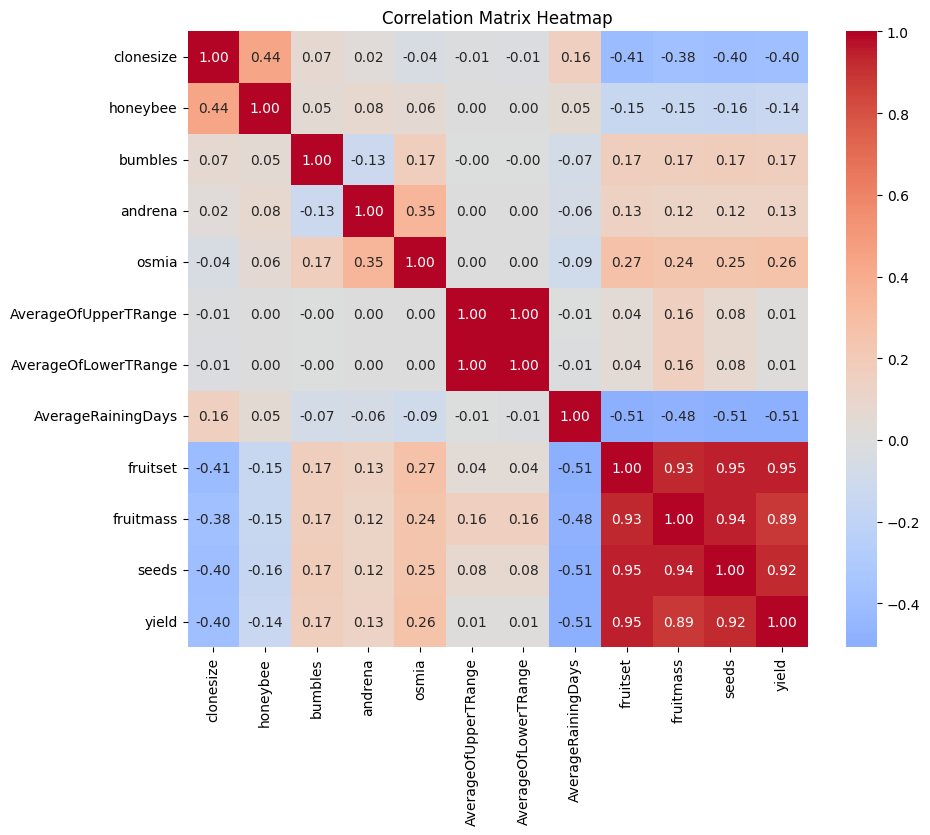

In [27]:
# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Correlation Matrix Heatmap")
plt.show()

## Define Hyperparameters

In [28]:
# Set hyperparameters.
learning_rate = 0.005
epochs = 70
batch_size = 10

# Filter features
excluded_columns = ['id', 'Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageRainingDays', 
       'yield']
filtered_features = [col for col in df_train.columns if col not in excluded_columns]


## Train Model on Training Data

In [ ]:
label = 'yield'
model = run_experiment(df_train, filtered_features, label, learning_rate, epochs, batch_size)

Starting training with features=['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'AverageOfUpperTRange', 'AverageOfLowerTRange', 'RainingDays', 'fruitset', 'fruitmass', 'seeds'] and label=yield

Epoch 1/70
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5660.6787 - mean_absolute_error: 5660.6787
Epoch 2/70
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4169.8159 - mean_absolute_error: 4169.8159
Epoch 3/70
 280/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3048.5076 - mean_absolute_error: 3048.5078

> 📌**Insights**
> 
> The model demonstrates excellent learning behavior. Error reduced sharply, from >5500 to <600. Training was stable, efficient, and well-behaved over 60 epochs. This indicates that both the model architecture and selected features are highly suitable for predicting agricultural yield.


> **Biological Inputs (Pollinators & Clone Size):**
> - Osmia (+105.5), Bumbles (+89.3), and Andrena (+86.3) have strong positive influence on yield, indicating that wild pollinators significantly contribute to pollination success.
> - Honeybee (+1.7) has a much weaker effect, suggesting limited additional benefit from managed honeybee presence compared to wild species.
> - Clone size (-28.4) shows a negative correlation, possibly due to resource competition in larger clones or diminishing returns with scale.
>
> **Environmental Factors (Temperature & Rain):**
> - Both Average Upper Temperature (+17.2) and Lower Temperature (+17.2) are positively associated with yield, suggesting that warmer growing conditions benefit plant productivity.
> - Raining Days (-31.9) has a negative impact, possibly due to reduced pollinator activity or poor fruit development during extended rain.
>
> **Direct Yield Contributors (Fruit Metrics):**
> - Fruitset (+163.6), Seeds (+134.0), and Fruitmass (+110.5) are the strongest predictors of yield, confirming they are proximate drivers of final production.
> - Their high positive weights suggest that interventions improving these fruit metrics would directly enhance yield.

# Evaluate Model
------------------

## Model Performance on Training Data

In [30]:
output = predict_fare(model, df_train, filtered_features, label)
show_predictions(output)


✅ Mean Absolute Error (MAE) for batch: 541.3338

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
    PREDICTED_YIELD  OBSERVED_YIELD      L1_LOSS  clonesize honeybee
0       4537.039062      3748.46547   788.573592       25.0     0.50
1       5552.830078      6595.45629  1042.626212       12.5     0.25
2       4809.502441      4200.97375   608.528691       25.0     0.50
3       5155.463379      5199.53404    44.070661       25.0     0.50
4       4613.315430      3720.71159   892.603840       25.0     0.50
5       5786.705078      5602.02293   184.682148       12.5     0.25
6       6515.262695      7637.63338  1122.370685       12.5     0.25
7       6085.996094      6529.98232   443.986226       25.0     0.50
8       5836.177734      6079.08526   242.907526       12.5     0.25
9       4932.3720

## Run Model on Test Data for Final Predictions

In [31]:
# Predict yield on test data
yield_pred = model.predict(df_test[filtered_features])


output_df = df_test[['id']].copy()
output_df['yield'] = yield_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [32]:
# Submit to competition
output_df.to_csv('submission5.csv', index=False)
print (" ✅ Output file successfully created.")

 ✅ Output file successfully created.


---
© 2025 Saurabh Kudesia

*This project is licensed under the [MIT License](https://opensource.org/licenses/MIT). You are free to use, modify, and distribute this code, provided you include proper attribution and retain the license notice.* [![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT)